In [1]:
#default_exp model3d

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [3]:
torch.cuda.set_device(4)

In [4]:
Meta.df_comb.shape

(752802, 47)

In [23]:
need data augmentation transforms

SyntaxError: invalid syntax (<ipython-input-23-7537a830ae40>, line 1)

In [24]:
need to resize to 128, then 256, then 512

SyntaxError: invalid syntax (<ipython-input-24-0e928efbca2a>, line 1)

In [8]:
dls = get_3d_dls(Meta.df_comb, bs=10)

In [9]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([10, 44, 3, 256, 256]), torch.Size([10, 44, 6]))

## Model

In [16]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048*2
        self.conv = nn.Sequential(
            ConvLayer(512, 1024, stride=2),
            ConvLayer(1024, 1024, stride=2),
            ConvLayer(1024, d_model, stride=2),
            AdaptiveConcatPool2d(),
#             nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        
        self.hook = ReshapeBodyHook(self.conv)
        hidden = 96
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=hidden, num_layers=2, bidirectional=True)
        self.head = nn.Sequential(
#             nn.Linear(hidden*2,hidden*4),
#             nn.ReLU(),
            nn.Linear(hidden*2,6)
        )
        
    def forward(self, x):
        x = self.conv(x)
        feat, _ = self.lstm(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [17]:
m = SeqHead()

In [18]:
config=dict(custom_head=m)
learn = get_learner(dls, xse_resnet50, get_loss(), config=config)

In [19]:
hook = ReshapeBodyHook(learn.model[0])
learn.add_cb(DePadLoss())

In [13]:
# learn.load(f'runs/baseline_full256-2', strict=False)

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(128, 

In [11]:
# learn.summary()

## Training

In [21]:
name = '3d_lstm_baselin'

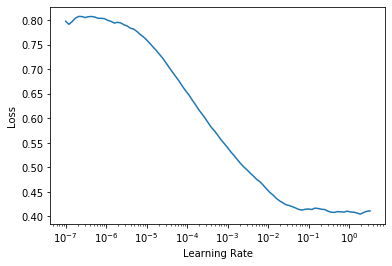

In [15]:
learn.lr_find()

In [22]:
do_fit(learn, 6, 1e-2, freeze=True)
learn.save(f'runs/{name}-1')

RuntimeError: CUDA out of memory. Tried to allocate 1.17 GiB (GPU 4; 23.65 GiB total capacity; 20.72 GiB already allocated; 400.00 MiB free; 1.75 GiB cached)